# Discrete Derham complex

The basics of the 3d Derham diagram are explained in the [struphy documentation](https://struphy.pages.mpcdf.de/struphy/sections/discretization.html).

![hi](../doc/pics/derham_complex.png)

The discrete complex in the above diagram (lower row) is loaded via the **Derham class**: 

In [13]:
import yaml
from mpi4py import MPI

import struphy
from struphy.psydac_api.psydac_derham import Derham

# use default input parameter file
path = struphy.__path__[0]
with open(path + '/io/inp/parameters.yml') as file:
    params = yaml.load(file, Loader=yaml.FullLoader)

Nel      = params['grid']['Nel']        # Number of grid cells
Nel[-1]  = 16 # use less points in third direction
p        = params['grid']['p']          # spline degrees
spl_kind = params['grid']['spl_kind']   # Spline types (clamped vs. periodic)

comm = MPI.COMM_WORLD
derham = Derham(Nel, p, spl_kind, comm=comm)

*Task 1:* Find out the number of elements, spline degrees and boundary conditions of the 1d spline spaces building up the tensor product bases.

In [14]:
derham.Nel

[4, 4, 16]

In [15]:
derham.p

[2, 2, 3]

In [16]:
derham.spl_kind

[True, True, True]

*Task 2:* Create an element of each discrete space $V_h^n$ and initialize it (resp. its first component only) with a sinusoidal function of mode number 2 and amplitude 0.5 in the third direction.

In [17]:
from struphy.psydac_api.fields import Field

p0 = Field('pressure', 'H1', derham)
E1 = Field('e_field', 'Hcurl', derham)
B2 = Field('b_field', 'Hdiv', derham)
n3 = Field('density', 'L2', derham)

init_params = {'type': 'ModesSin', 'coords': 'logical', 'ModesSin': {'ls': [0], 'ms': [0], 'ns': [2], 'amp': [.5]}}
p0.initialize_coeffs([True], init_params)
E1.initialize_coeffs([True, False, False], init_params)
B2.initialize_coeffs([True, False, False], init_params)
n3.initialize_coeffs([True], init_params)

Setting initial conditions for pressure in H1 ...
Done.
Setting initial conditions for e_field in Hcurl ...
Done.
Setting initial conditions for b_field in Hdiv ...
Done.
Setting initial conditions for density in L2 ...
Done.


*Task 3:* Evaluate the 0-form, squeeze output and plot the result alongside the continuous sinusoidal function.

The evaluation output is a numpy array (squeezed in this case):

[-1.04083409e-17  1.26604817e-01  2.45218989e-01  3.47851868e-01
  4.27155621e-01  4.78885241e-01  4.99730705e-01  4.87121287e-01
  4.42802409e-01  3.70081750e-01  2.72687589e-01  1.57319618e-01
  3.19633390e-02 -9.53906016e-02 -2.16751558e-01 -3.24128883e-01
 -4.09785437e-01 -4.68718935e-01 -4.97595735e-01 -4.93375357e-01
 -4.56674086e-01 -3.90743575e-01 -2.99032505e-01 -1.87410149e-01
 -6.38018241e-02  6.38018241e-02  1.87410149e-01  2.99032505e-01
  3.90743575e-01  4.56674086e-01  4.93375357e-01  4.97595735e-01
  4.68718935e-01  4.09785437e-01  3.24128883e-01  2.16751558e-01
  9.53906016e-02 -3.19633390e-02 -1.57319618e-01 -2.72687589e-01
 -3.70081750e-01 -4.42802409e-01 -4.87121287e-01 -4.99730705e-01
 -4.78885241e-01 -4.27155621e-01 -3.47851868e-01 -2.45218989e-01
 -1.26604817e-01 -1.04083409e-17]


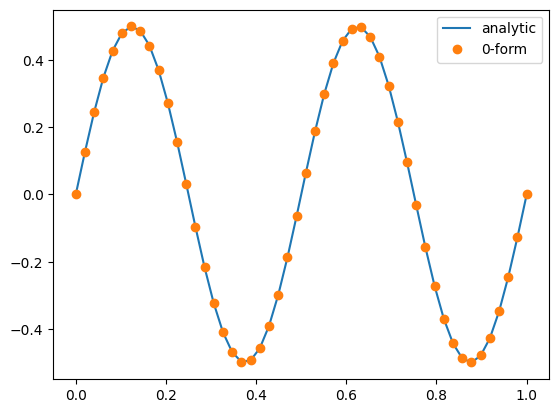

In [18]:
import numpy as np
from matplotlib import pyplot as plt

# sinusoidal
fun = lambda x, y, z : .5*np.sin(2*2*np.pi*z)

# evaluation points
eta1 = 0
eta2 = 0
eta3 = np.linspace(0., 1., 50)

# evaluate 0-form
p0_vals = p0(eta1, eta2, eta3, squeeze_output=True)
print('The evaluation output is a numpy array (squeezed in this case):\n')
print(p0_vals)

# plot
plt.plot(eta3, fun(0, 0, eta3), label='analytic')
plt.plot(eta3, p0_vals, 'o', label='0-form')
plt.legend()

*Task 4:* Evaluate the 1-form, squeeze output and plot the result alongside the continuous sinusoidal function.

The evaluation output is a list of numpy arrays (squeezed in this case):

[array([ 0.        ,  0.12660482,  0.24521899,  0.34785187,  0.42715562,
        0.47888524,  0.4997307 ,  0.48712129,  0.44280241,  0.37008175,
        0.27268759,  0.15731962,  0.03196334, -0.0953906 , -0.21675156,
       -0.32412888, -0.40978544, -0.46871894, -0.49759574, -0.49337536,
       -0.45667409, -0.39074358, -0.29903251, -0.18741015, -0.06380182,
        0.06380182,  0.18741015,  0.29903251,  0.39074358,  0.45667409,
        0.49337536,  0.49759574,  0.46871894,  0.40978544,  0.32412888,
        0.21675156,  0.0953906 , -0.03196334, -0.15731962, -0.27268759,
       -0.37008175, -0.44280241, -0.48712129, -0.4997307 , -0.47888524,
       -0.42715562, -0.34785187, -0.24521899, -0.12660482,  0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

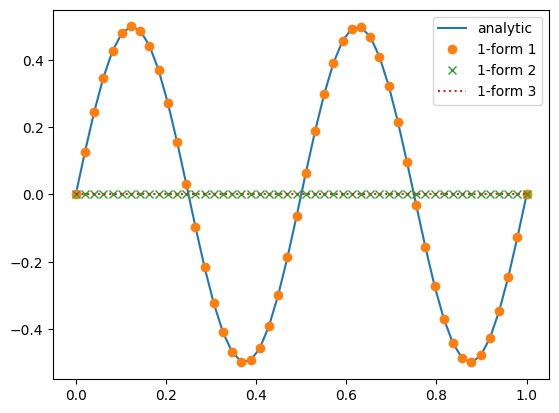

In [19]:
# evaluate 1-form
E1_vals = E1(eta1, eta2, eta3, squeeze_output=True)
print('The evaluation output is a list of numpy arrays (squeezed in this case):\n')
print(E1_vals)

# plot
plt.plot(eta3, fun(0, 0, eta3), label='analytic')
plt.plot(eta3, E1_vals[0], 'o', label='1-form 1')
plt.plot(eta3, E1_vals[1], 'x', label='1-form 2')
plt.plot(eta3, E1_vals[2], ':', label='1-form 3')
plt.legend()

*Task 5*: Project the sinusoidal function into $V_h^0$. Also, project its gradient into $V_h^1$.

In [20]:
fun_h = derham.P0(fun)
print('Result of P0 projection is a Femfield:', fun_h)

dx_fun = lambda x, y, z : 0.
dy_fun = lambda x, y, z : 0.
dz_fun = lambda x, y, z : 2*2*np.pi*.5*np.cos(2*2*np.pi*z)
grad_h = derham.P1((dx_fun, dy_fun, dz_fun))
print('Result of P1 projection is a Femfield:', grad_h)

Result of P0 projection is a Femfield: <psydac.fem.basic.FemField object at 0x7f41388dd5b0>
Result of P1 projection is a Femfield: <psydac.fem.basic.FemField object at 0x7f413da91580>


*Task 6:* Get the FE coefficients of the projected function and apply the discrete gradient operator.

In [21]:
c_fun = fun_h.coeffs
print('Coefficients in V0 are a StencilVector:', type(c_fun))

c_grad = derham.grad.dot(c_fun)
print('Coefficients in V1 are a BlockVector:', type(c_grad))

Coefficients in V0 are a StencilVector: <class 'psydac.linalg.stencil.StencilVector'>
Coefficients in V1 are a BlockVector: <class 'psydac.linalg.block.BlockVector'>


*Task 7:* Check the commuting property.

In [22]:
assert np.allclose(grad_h.coeffs[0].toarray(), c_grad[0].toarray())
assert np.allclose(grad_h.coeffs[1].toarray(), c_grad[1].toarray())
assert np.allclose(grad_h.coeffs[2].toarray(), c_grad[2].toarray())

### Other Derham object properties:

In [23]:
# Derham discretization attributes
print(f'derham.bc: {Derham.bc.__doc__} {derham.bc}\n')
print(f'derham.quad_order: {Derham.quad_order.__doc__} {derham.quad_order}\n')
print(f'derham.nq_pr: {Derham.nq_pr.__doc__} {derham.nq_pr}')

derham.bc:  List of boundary conditions in each direction.
         [[None, None], [None, None], [None, None]]

derham.quad_order:  List of number of Gauss-Legendre quadrature points in each direction (default = p, = p + 1 points per cell).
         [2, 2, 3]

derham.nq_pr:  List of number of Gauss-Legendre quadrature points in histopolation (default = p + 1) in each direction.
         [3, 3, 4]


In [24]:
# Derham misc attributes
print(f'derham.der_as_mat: {Derham.der_as_mat.__doc__} {derham.der_as_mat}\n')
print(f'derham.breaks: {Derham.breaks.__doc__} {derham.breaks}\n')

derham.der_as_mat:  Whether derivatives are returned as matrices (True) or operators (False).
         True

derham.breaks:  List of break points (=cell interfaces) in each direction.
         [array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    ])]



In [25]:
# Derham global spline index attributes
print(f'derham.indN: {Derham.indN.__doc__} {derham.indN}\n')
print(f'derham.indD: {Derham.indD.__doc__} {derham.indD}')

derham.indN:  List of 2d arrays holding global spline indices (N) in each element in the three directions.
         [array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 0],
       [3, 0, 1]]), array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 0],
       [3, 0, 1]]), array([[ 0,  1,  2,  3],
       [ 1,  2,  3,  4],
       [ 2,  3,  4,  5],
       [ 3,  4,  5,  6],
       [ 4,  5,  6,  7],
       [ 5,  6,  7,  8],
       [ 6,  7,  8,  9],
       [ 7,  8,  9, 10],
       [ 8,  9, 10, 11],
       [ 9, 10, 11, 12],
       [10, 11, 12, 13],
       [11, 12, 13, 14],
       [12, 13, 14, 15],
       [13, 14, 15,  0],
       [14, 15,  0,  1],
       [15,  0,  1,  2]])]

derham.indD:  List of 2d arrays holding global spline indices (D) in each element in the three directions.
         [array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 0]]), array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 0]]), array([[ 0,  1,  2],
       [ 1,  2,  3],
       [ 2,  3,  4],
       [ 3,  4,  5],
       

In [26]:
# Derham parallel attributes
print(f'derham.comm: {Derham.comm.__doc__} {derham.comm}\n')
print(f'derham.domain_array: {Derham.domain_array.__doc__} {derham.domain_array}\n')
print(f'derham.index_array_N: {Derham.index_array_N.__doc__} {derham.index_array_N}\n')
print(f'derham.index_array_D: {Derham.index_array_D.__doc__} {derham.index_array_D}\n')
print(f'derham.neighbours: {Derham.neighbours.__doc__} {derham.neighbours}')

derham.comm:  MPI communicator.

derham.domain_array: 
        A 2d array[float] of shape (comm.Get_size(), 9). The row index denotes the process number and
        for n=0,1,2: 

            * domain_array[i, 3*n + 0] holds the LEFT domain boundary of process i in direction eta_(n+1).
            * domain_array[i, 3*n + 1] holds the RIGHT domain boundary of process i in direction eta_(n+1).
            * domain_array[i, 3*n + 2] holds the number of cells of process i in direction eta_(n+1).
         [[ 0.  1.  4.  0.  1.  4.  0.  1. 16.]]

derham.index_array_N: 
        A 2d array[int] of shape (comm.Get_size(), 6). The row index denotes the process number and
        for n=0,1,2:

            * arr[i, 2*n + 0] holds the global start index of B-splines (N) of process i in direction eta_(n+1).
            * arr[i, 2*n + 1] holds the global end index of B-splines (N) of process i in direction eta_(n+1).
         [[ 0  3  0  3  0 15]]

derham.index_array_D: 
        A 2d array[int] of sh

### All these operations also work in parallel !